In [68]:
from typing import Self

import numpy as np
import scipy.sparse as sp
import scanpy as sc

sc.logging.print_header()

scanpy==1.10.0rc2.dev0+g48b495d9.d20240222 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [69]:
%pip install -qU pip
%pip install -q annoy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [70]:
adata = sc.datasets.paul15()
sc.pp.pca(adata)
adata_annoy, adata_default = adata.copy(), adata.copy()

In [71]:
from attr import dataclass, asdict
from sklearn.base import TransformerMixin
from annoy import AnnoyIndex

@dataclass
class AnnoyTransformer(TransformerMixin):
    n_neighbors: int
    # metric, ...

    _index: AnnoyIndex | None = None
    
    get_params = asdict

    def fit(self, data: np.ndarray) -> Self:
        self._index = AnnoyIndex(data.shape[1], 'euclidean')
        for i, v in enumerate(data):
            self._index.add_item(i, v)
        self._index.build(n_trees=10, n_jobs=4)
        return self

    def transform(self, data: object) -> sp.csr_matrix:
        # We ignore the data parameter and expect it to be the same as for `fit`
        n_samples = self._index.get_n_items()

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        n_neighbors = self.n_neighbors + 1

        indices = np.empty((n_samples, n_neighbors), dtype=int)
        distances = np.empty((n_samples, n_neighbors))

        for i in range(self._index.get_n_items()):
            ind, dist = self._index.get_nns_by_item(
                i, n_neighbors, -1, include_distances=True
            )

            indices[i], distances[i] = ind, dist

        indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
        kneighbors_graph = sp.csr_matrix(
            (distances.ravel(), indices.ravel(), indptr),
            shape=(n_samples, n_samples),
        )

        return kneighbors_graph

In [72]:
%timeit sc.pp.neighbors(adata_annoy, transformer=AnnoyTransformer(15))

54.3 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%timeit sc.pp.neighbors(adata_default, transformer="pynndescent", n_neighbors=15)

691 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
for adata in [adata_annoy, adata_default]:
    sc.tl.leiden(adata, flavor="igraph")
    sc.tl.umap(adata)

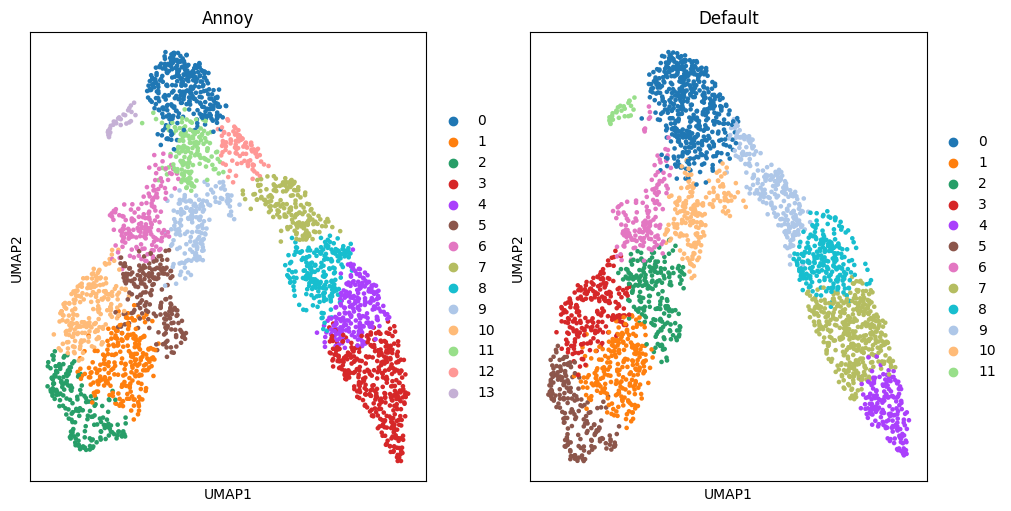

In [84]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sc.pl.umap(adata_annoy, title="Annoy", color="leiden", ax=axs[0], show=False)
sc.pl.umap(adata_default, title="Default", color="leiden", ax=axs[1], show=False)
fig